# Tugas Besar A
IF3270 Pembelajaran Mesin<br>
Forward Propagation - Feed Forward Neural Network (FFNN)

Developed by:
1. K01 13520010 - Ken Kalang Al Qalyubi
2. K01 13520036 - I Gede Arya Raditya Parameswara
3. K02 13520061 - Gibran Darmawan
4. K03 13520119 - Marchotridyo

## Main Program

### Library

In [553]:
import json, math
import networkx as nx
import matplotlib.pyplot as plt
from enum import Enum

### Enum

In [554]:
class LayerEnum(Enum):
    INPUT = "INPUT"
    HIDDEN = "HIDDEN"
    OUTPUT = "OUTPUT"

class ActivationFuncEnum(Enum):
    SIGMOID = "SIGMOID"
    LINEAR = "LINEAR"
    RELU = "RELU"
    SOFTMAX = "SOFTMAX"

### File Utility

In [555]:
class FileUtility:
    @staticmethod
    def import_json(file_name):
        with open(file_name) as json_file:
            return json.load(json_file)

    @staticmethod
    def export_json(file_name, data):
        with open(file_name, 'w') as outfile:
            json.dump(data, outfile)

### Layer

In [556]:
class Layer:
    # Layer adalah kelas yang menyimpan sejumlah neutron berikut fungsi aktivasinya
    def __init__(self, neurons: list, type: str, activation_func: str):
        self.__neurons = neurons
        self.__type = type
        self.__activation_func = activation_func

    def add_neuron(self, neuron):
        self.__neurons.append(neuron)

    def get_neurons(self):
        return self.__neurons
    
    def get_type(self):
        return self.__type
    
    def get_activation_func(self):
        return self.__activation_func

### Neuron

In [557]:
class Neuron:
    def __init__(
        self, 
        layer: Layer,
        weight: list,
        bias: list, 
    ):
        self.__layer: Layer = layer
        self.__weight: list = weight
        self.__bias: list = bias
        self.__net: float = 0.0
        self.__value: float = 0.0

    def activate(self):
        if self.__layer.get_activation_func() == ActivationFuncEnum.SIGMOID.value:
            self.__value = 1 / (1 + math.exp(-self.__net))
        elif self.__layer.get_activation_func() == ActivationFuncEnum.LINEAR.value:
            self.__value = self.__net
        elif self.__layer.get_activation_func() == ActivationFuncEnum.RELU.value:
            self.__value = max(0, self.__net)
        elif self.__layer.get_activation_func() == ActivationFuncEnum.SOFTMAX.value:
            layer_neurons: list = self.__layer.get_neurons()
            exp_sum: float = 0.0

            for neuron in layer_neurons:
                exp_sum += math.exp(neuron.get_net())

            self.__value = math.exp(self.__net) / exp_sum

    def set_value(self, value):
        self.__value = value

    def set_net(self, net):
        self.__net = net

    def get_value(self):
        return self.__value

    def get_net(self):
        return self.__net

    def get_weight(self, index):
        return self.__weight[index]

    def get_weights(self):
        return self.__weight

    def get_bias(self):
        return self.__bias
    
    def get_layer(self):
        return self.__layer

### ANN Graph

In [558]:
class ANNGraph:
    def __init__(self, file_config_path: str):
        self.file_path = file_config_path
        self.config = None

        self.layers: list[Layer] = []
        self.build_ann_graph()

    def build_ann_graph(self):
        self.config = FileUtility.import_json(self.file_path)
        layers = self.config["layers"]

        for layer in layers:
            # Untuk setiap layer, persiapkan neuronnya
            curr_layer = Layer([], layer["type"], layer["activation_func"])

            for neuron_data in layer["neurons"]:
                neuron = self.__generate_neuron_data(curr_layer, neuron_data)
                curr_layer.add_neuron(neuron)

            self.layers.append(curr_layer)

        return
    
    def draw_ann_graph(self):
        # Terminologies:
        # Xi = neuron ke-i di input layer
        # Hij = neuron ke-j di hidden layer ke-i
        # Oi = neuron ke-i di output layer

        G = nx.DiGraph()

        # Proses setiap layer
        for i, layer in enumerate(self.layers):
            if i == 0:
                continue

            prev_layer = self.layers[i - 1]
            prev_prefix = ""
            prefix = ""

            if prev_layer.get_type() == LayerEnum.INPUT.value:
                prev_prefix = "X"
            elif prev_layer.get_type() == LayerEnum.HIDDEN.value:
                prev_prefix = f"H{i - 1}"
            else:
                prev_prefix = "O"
            
            if layer.get_type() == LayerEnum.INPUT.value:
                prefix = "X"
            elif layer.get_type() == LayerEnum.HIDDEN.value:
                prefix = f"H{i}"
            else:
                prefix = "O"

            # Tambahkan edge dari setiap neuron di prev_layer ke layer
            for j, _ in enumerate(prev_layer.get_neurons()):
                for k, neuron in enumerate(layer.get_neurons()):
                    if j == 0:
                        print(f"Bobot bias untuk {prefix}{k + 1} = {neuron.get_weight(0)}")
                    G.add_edge(f"{prev_prefix}{j + 1}", f"{prefix}{k + 1}", weight=neuron.get_weight(j + 1))
            
        # Set posisi node graph
        pos = {}
        curr_x = 0
        for i, layer in enumerate(self.layers):
            curr_y = 0

            prefix = ""
            if layer.get_type() == LayerEnum.INPUT.value:
                prefix = "X"
            elif layer.get_type() == LayerEnum.HIDDEN.value:
                prefix = f"H{i}"
            else:
                prefix = "O"
            
            for j, _ in enumerate(layer.get_neurons()):
                pos[f"{prefix}{j + 1}"] = (curr_x, curr_y)
                curr_y += 1

            curr_x += 1

        options = {
            "font_size": 12,
            "node_size": 2000,
            "node_color": "white",
            "edgecolors": "black",
            "linewidths": 5,
            "width": 5,
        }

        nx.draw_networkx(G, pos, **options)
        edge_labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels, label_pos=0.6)

        ax = plt.gca()
        ax.margins(0.2)
        plt.axis("off")
        plt.show()

    def predict(self, input_data):
        for i in range(len(input_data)):
            # Masukkan input_data ke neuron di input layer
            neuron: Neuron = self.layers[0].get_neurons()[i]
            neuron.set_value(input_data[i])

        self.__activate_all_neurons()

        return

    def print_details(self):
        for i, layer in enumerate(self.layers):
            print("--------------------")
            print(f"Layer {i+1} ({layer.get_type()})")
            if layer.get_type() != LayerEnum.INPUT.value:
                print(f"Activation function: {layer.get_activation_func()}")
            print("--------------------")
            if layer.get_type() != LayerEnum.INPUT.value:
                for j, neuron in enumerate(layer.get_neurons()):
                    print(f"[Neuron {j+1}] Net:", neuron.get_net())
                    print(f"[Neuron {j+1}] Value:", neuron.get_value())
            else:
                for j, neuron in enumerate(layer.get_neurons()):
                    print(f"[Neuron {j+1}] is supplied value of {neuron.get_value()}")
            print("")

    def __generate_neuron_data(self, layer: Layer, neuron_data):
        weights: list = []
        bias: list = []

        if (layer.get_type() == LayerEnum.HIDDEN.value or layer.get_type() == LayerEnum.OUTPUT.value):
            weights = neuron_data["weights"]
            bias = neuron_data["bias"]

        return Neuron(layer, weights, bias)
    
    def __activate_all_neurons(self):
        for i, layer in enumerate(self.layers):
            if layer.get_type() == LayerEnum.INPUT.value:
                continue # Tidak perlu activate untuk input layer

            previous_layer = self.layers[i - 1]
            for neuron in layer.get_neurons():
                self.__calculate_neuron_net(neuron, previous_layer)
                neuron.activate()

        return

    def __calculate_neuron_net(self, neuron: Neuron, previous_layer: Layer):
        total = 0.0

        for i, prev_neuron in enumerate(previous_layer.get_neurons()):
            # i + 1 karena i = 0 adalah weight dari bias
            total += prev_neuron.get_value() * neuron.get_weight(i + 1)

        total += neuron.get_bias() * neuron.get_weight(0)

        neuron.set_net(total)

## Testing

### Sigmoid

Bobot bias untuk H11 = -10
Bobot bias untuk H12 = 30
Bobot bias untuk O1 = -30


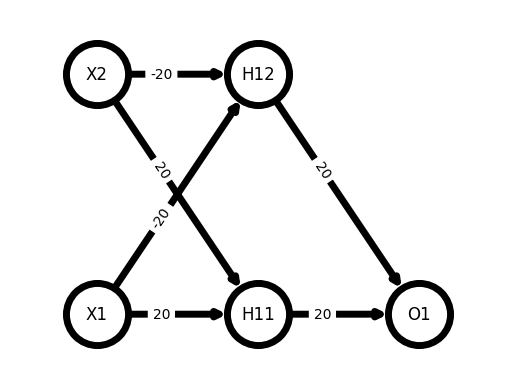

In [559]:
# Load graph
graph = ANNGraph("config/xor_sigmoid.json")
graph.draw_ann_graph()

In [560]:
print("**Untuk x1 = 0 dan x2 = 0:**")
graph.predict([0, 0])
graph.print_details()

**Untuk x1 = 0 dan x2 = 0:**
--------------------
Layer 1 (INPUT)
--------------------
[Neuron 1] is supplied value of 0
[Neuron 2] is supplied value of 0

--------------------
Layer 2 (HIDDEN)
Activation function: SIGMOID
--------------------
[Neuron 1] Net: -10.0
[Neuron 1] Value: 4.5397868702434395e-05
[Neuron 2] Net: 30.0
[Neuron 2] Value: 0.9999999999999065

--------------------
Layer 3 (OUTPUT)
Activation function: SIGMOID
--------------------
[Neuron 1] Net: -9.999092042627819
[Neuron 1] Value: 4.543910487654591e-05



In [561]:
print("**Untuk x1 = 0 dan x2 = 1:**")
graph.predict([0, 1])
graph.print_details()

**Untuk x1 = 0 dan x2 = 1:**
--------------------
Layer 1 (INPUT)
--------------------
[Neuron 1] is supplied value of 0
[Neuron 2] is supplied value of 1

--------------------
Layer 2 (HIDDEN)
Activation function: SIGMOID
--------------------
[Neuron 1] Net: 10.0
[Neuron 1] Value: 0.9999546021312976
[Neuron 2] Net: 10.0
[Neuron 2] Value: 0.9999546021312976

--------------------
Layer 3 (OUTPUT)
Activation function: SIGMOID
--------------------
[Neuron 1] Net: 9.998184085251907
[Neuron 1] Value: 0.999954519621495



In [562]:
print("**Untuk x1 = 1 dan x2 = 0:**")
graph.predict([1, 0])
graph.print_details()

**Untuk x1 = 1 dan x2 = 0:**
--------------------
Layer 1 (INPUT)
--------------------
[Neuron 1] is supplied value of 1
[Neuron 2] is supplied value of 0

--------------------
Layer 2 (HIDDEN)
Activation function: SIGMOID
--------------------
[Neuron 1] Net: 10.0
[Neuron 1] Value: 0.9999546021312976
[Neuron 2] Net: 10.0
[Neuron 2] Value: 0.9999546021312976

--------------------
Layer 3 (OUTPUT)
Activation function: SIGMOID
--------------------
[Neuron 1] Net: 9.998184085251907
[Neuron 1] Value: 0.999954519621495



In [563]:
print("**Untuk x1 = 1 dan x2 = 1:**")
graph.predict([1, 1])
graph.print_details()

**Untuk x1 = 1 dan x2 = 1:**
--------------------
Layer 1 (INPUT)
--------------------
[Neuron 1] is supplied value of 1
[Neuron 2] is supplied value of 1

--------------------
Layer 2 (HIDDEN)
Activation function: SIGMOID
--------------------
[Neuron 1] Net: 30.0
[Neuron 1] Value: 0.9999999999999065
[Neuron 2] Net: -10.0
[Neuron 2] Value: 4.5397868702434395e-05

--------------------
Layer 3 (OUTPUT)
Activation function: SIGMOID
--------------------
[Neuron 1] Net: -9.999092042627819
[Neuron 1] Value: 4.543910487654591e-05

